<a href="https://colab.research.google.com/github/kkokay07/Learning-Machine-Learning/blob/main/Regression%20Models/Advanced_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Regression Models

## 1. Ridge Regression (L2 Regularization)

### Mathematical Foundation
Objective Function: min(||y - Xβ||² + α||β||²)
- α: Regularization parameter
- ||β||²: L2 norm of coefficients

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression

In [2]:
# Generate sample dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

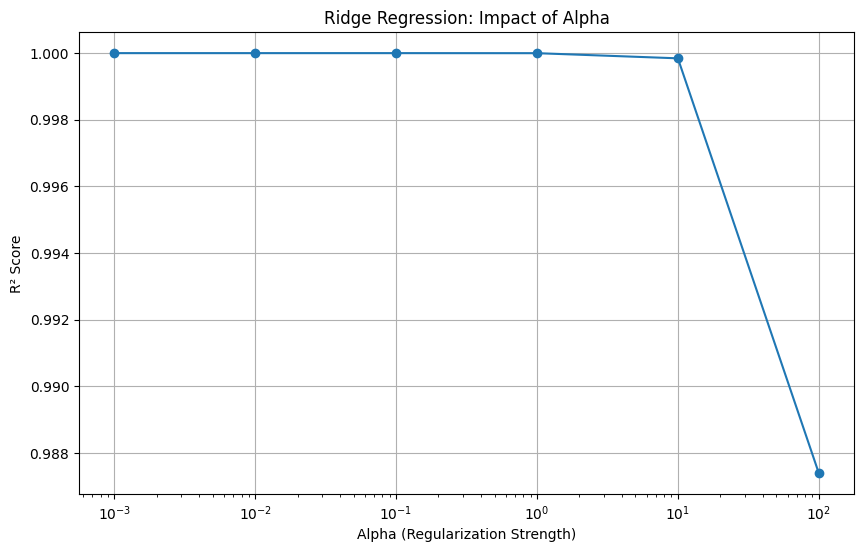

In [3]:
# Ridge Regression Implementation
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    score = ridge.score(X_test_scaled, y_test)
    ridge_scores.append(score)

# Visualization of Ridge alpha impact
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, ridge_scores, marker='o')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R² Score')
plt.title('Ridge Regression: Impact of Alpha')
plt.grid(True)

### Key Characteristics:
1. Shrinks coefficients towards zero
2. Handles multicollinearity
3. Never sets coefficients exactly to zero
4. Useful when all features are important

## 2. Lasso Regression (L1 Regularization)

### Mathematical Foundation
Objective Function: min(||y - Xβ||² + α||β||₁)
- α: Regularization parameter
- ||β||₁: L1 norm of coefficients

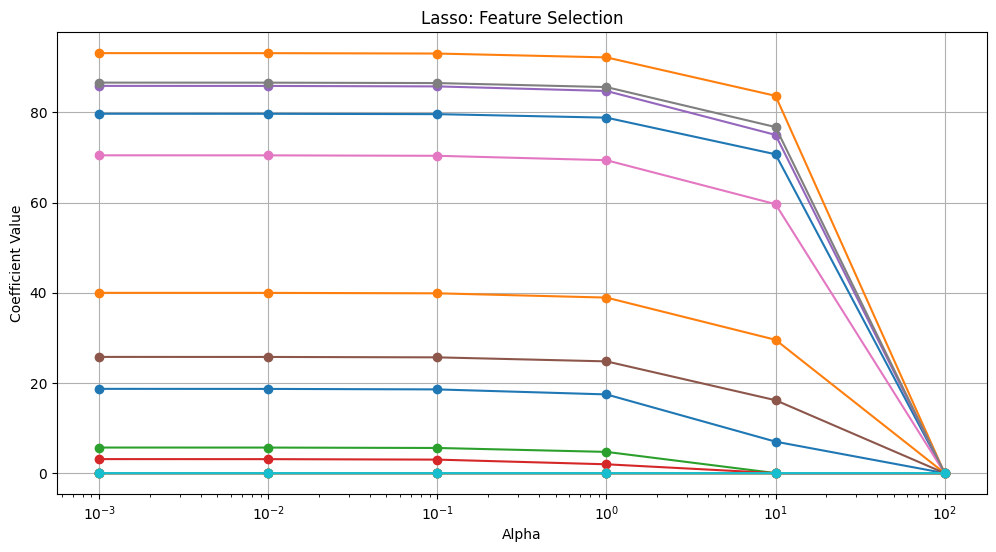

In [4]:
# Lasso Implementation
lasso_scores = []
lasso_coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    score = lasso.score(X_test_scaled, y_test)
    lasso_scores.append(score)
    lasso_coefs.append(lasso.coef_)

# Visualization of Lasso feature selection
plt.figure(figsize=(12, 6))
for coef in zip(*lasso_coefs):
    plt.plot(alphas, coef, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso: Feature Selection')
plt.grid(True)

### Key Characteristics:
1. Performs feature selection
2. Sets coefficients exactly to zero
3. Sparse solutions
4. Good for high-dimensional data

## 3. Elastic Net

### Mathematical Foundation
Objective Function: min(||y - Xβ||² + α₁||β||₁ + α₂||β||²)
- α₁: L1 regularization parameter
- α₂: L2 regularization parameter

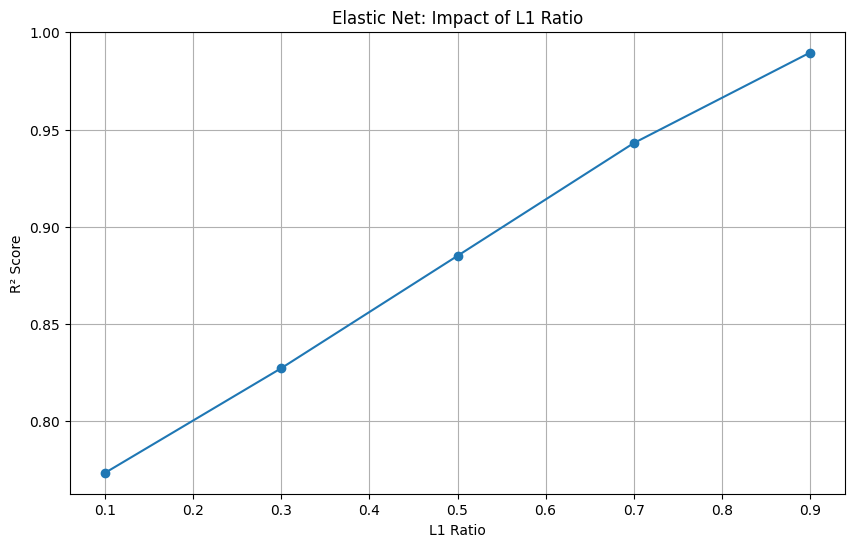

In [5]:
# Elastic Net Implementation
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha = 1.0
elastic_net_scores = []

for l1_ratio in l1_ratios:
    elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic.fit(X_train_scaled, y_train)
    score = elastic.score(X_test_scaled, y_test)
    elastic_net_scores.append(score)

# Visualization of Elastic Net performance
plt.figure(figsize=(10, 6))
plt.plot(l1_ratios, elastic_net_scores, marker='o')
plt.xlabel('L1 Ratio')
plt.ylabel('R² Score')
plt.title('Elastic Net: Impact of L1 Ratio')
plt.grid(True)

### Key Characteristics:
1. Combines L1 and L2 regularization
2. Handles correlated features better than Lasso
3. Can perform feature selection
4. More flexible than Ridge or Lasso alone

## 4. Model Comparison and Selection

In [6]:
# Compare all models
def compare_models(X_train, X_test, y_train, y_test, alpha=1.0):
    models = {
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha),
        'ElasticNet': ElasticNet(alpha=alpha, l1_ratio=0.5)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MSE': mse, 'R²': r2}

    return pd.DataFrame(results).T

comparison = compare_models(X_train_scaled, X_test_scaled, y_train, y_test)
print("\nModel Comparison:")
print(comparison)


Model Comparison:
                    MSE        R²
Ridge          0.072016  0.999998
Lasso         10.598757  0.999726
ElasticNet  4447.022215  0.885116


## 5. Cross-Validation and Hyperparameter Tuning

In [7]:
def tune_model(model, param_grid, X, y):
    grid_search = GridSearchCV(
        model, param_grid,
        cv=5, scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

# Ridge tuning
ridge_params = {'alpha': alphas}
ridge_best_params, ridge_best_score = tune_model(
    Ridge(), ridge_params, X_train_scaled, y_train
)

# Lasso tuning
lasso_params = {'alpha': alphas}
lasso_best_params, lasso_best_score = tune_model(
    Lasso(), lasso_params, X_train_scaled, y_train
)

# Elastic Net tuning
elastic_params = {
    'alpha': alphas,
    'l1_ratio': l1_ratios
}
elastic_best_params, elastic_best_score = tune_model(
    ElasticNet(), elastic_params, X_train_scaled, y_train
)

## 6. Feature Importance Analysis

In [8]:
def plot_feature_importance(model, feature_names=None):
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(model.coef_))]

    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': np.abs(model.coef_)
    }).sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(12, 6))
    plt.bar(coefficients['Feature'], coefficients['Coefficient'])
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.ylabel('|Coefficient|')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return coefficients

## 7. Practical Example: Gene Expression Analysis

In [9]:
# Generate synthetic gene expression data
n_genes = 1000
n_samples = 100
X_genes = np.random.normal(0, 1, (n_samples, n_genes))
y_expression = np.dot(X_genes[:, :10], np.random.normal(0, 1, 10)) + np.random.normal(0, 0.1, n_samples)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X_genes, y_expression, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Elastic Net
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)

# Identify important genes
important_genes = np.where(elastic.coef_ != 0)[0]
print(f"\nNumber of selected genes: {len(important_genes)}")


Number of selected genes: 92


## 8. Best Practices

1. **Model Selection Guidelines:**
   - Use Ridge when all features are important
   - Use Lasso for feature selection
   - Use Elastic Net for correlated features
   - Consider computational resources

2. **Preprocessing Requirements:**
   - Always scale features
   - Handle missing values
   - Remove or encode categorical variables
   - Check for multicollinearity

3. **Hyperparameter Tuning:**
   - Use cross-validation
   - Try logarithmic scale for alpha
   - Consider computational budget
   - Monitor for overfitting

4. **Validation Strategies:**
   - Hold-out validation
   - K-fold cross-validation
   - Time series cross-validation
   - Nested cross-validation

## 9. Common Issues and Solutions

1. **Convergence Issues:**
   - Increase max_iter
   - Adjust tolerance
   - Scale features
   - Try different solvers

2. **Feature Selection Stability:**
   - Use bootstrap sampling
   - Ensemble methods
   - Cross-validation
   - Stability selection

3. **Interpretation:**
   - Scale features for coefficient comparison
   - Use feature importance plots
   - Consider domain knowledge
   - Validate with experts

4. **Model Selection:**
   - Use nested cross-validation
   - Consider computational cost
   - Balance complexity vs performance
   - Monitor stability of solutions